In [298]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [299]:
import numpy as np
import pandas as pd
import random

In [300]:
def generatesequences(init, tran, emis, seqnum):
    corpus = {}
    for i in range(0, seqnum):
        curseq = []
        for curpos in range(0, random.randint(30, 40)):
            if curpos == 0:
                curstate = np.random.choice(
                    a=list(init.keys()), p=list(init.values()))
            else:
                curstate = np.random.choice(
                    a=tran.columns.tolist(), p=tran.loc[curstate, :].tolist())
            curseq.append(
                np.random.choice(
                    a=emis.columns.tolist(), p=emis.loc[curstate, :].tolist()))
        curseq = tuple(curseq)
        if curseq not in corpus:
            corpus[curseq] = {'count': 1}
        else:
            corpus[curseq]['count'] += 1
    return corpus

In [301]:
def randomizedf(dfin):
    for i in dfin.index:
        for j in dfin.columns:
            dfin.loc[i, j] = random.random()
        priorsum = sum(dfin.loc[i, :])
        dfin.loc[i, :] = dfin.loc[i, :] / priorsum
    return dfin

def randomizepriors(priors):
    #init
    for key in priors[0]:
        priors[0][key] = random.random()
    priorsum = sum(priors[0].values())
    for key in priors[0]:
        priors[0][key] = priors[0][key] / priorsum
    for i in range(1, 2 + 1):
        randomizedf(priors[i])

    return priors

In [302]:
def alpha(corpus, priors, states):
    init = priors[0]
    tran = priors[1]
    emis = priors[2]
    for sequence in corpus:
        seqiter = range(0, len(sequence))
        forward = pd.DataFrame(0, index=states, columns=seqiter)
        for position in seqiter:
            for state in states:
                if position == 0:
                    forward.loc[state, position] = init[state] * emis.loc[
                        state, sequence[position]]
                else:
                    for prevstate in states:
                        forward.loc[state, position] += forward.loc[
                            prevstate, position - 1] * tran.loc[
                                prevstate, state] * emis.loc[state, sequence[
                                    position]]
        corpus[sequence]['alpha'] = forward
        corpus[sequence]['prob'] = sum(forward.loc[:, len(sequence) - 1])
        forward = None
    return corpus

In [303]:
def beta(corpus, priors, states):
    init = priors[0]
    tran = priors[1]
    emis = priors[2]
    for sequence in corpus:
        seqiter = range(len(sequence) - 1, -1, -1)
        backward = pd.DataFrame(0, index=states, columns=seqiter)
        for position in seqiter:
            for state in states:
                if position == len(sequence) - 1:
                    backward.loc[state, position] = 1
                else:
                    for nextstate in states:
                        backward.loc[state, position] += tran.loc[
                            state, nextstate] * emis.loc[nextstate, sequence[
                                position + 1]] * backward.loc[nextstate,
                                                              position + 1]
        corpus[sequence]['beta'] = backward
        backward = None
    return corpus

In [304]:
def xi(corpus, priors, states):
    init = priors[0]
    tran = priors[1]
    emis = priors[2]
    for sequence in corpus:
        seqiter = range(0, len(sequence) - 1)
        path = pd.DataFrame(
            0,
            index=pd.MultiIndex.from_product([states, states]),
            columns=seqiter)
        for position in seqiter:
            for state1 in states:
                for state2 in states:
                    path.loc[(state1, state2), position] = corpus[sequence][
                        'alpha'].loc[state1, position] * tran.loc[
                            state1, state2] * emis.loc[state2, sequence[
                                position + 1]] * corpus[sequence]['beta'].loc[
                                    state2, position + 1] / corpus[sequence][
                                        'prob']
        corpus[sequence]['xi'] = path
    return corpus

In [305]:
def gamma(corpus, priors, states):
    init = priors[0]
    tran = priors[1]
    emis = priors[2]
    for sequence in corpus:
        seqiter = range(0, len(sequence))
        single = pd.DataFrame(0, index=states, columns=seqiter)
        for position in seqiter:
            for state in states:
                if position == len(sequence) - 1:
                    single.loc[state, position] += corpus[sequence][
                        'alpha'].loc[state, position] / corpus[sequence][
                            'prob']
                else:
                    for nextstate in states:
                        single.loc[state, position] += corpus[sequence][
                            'xi'].loc[(state, nextstate), position]
        corpus[sequence]['gamma'] = single
    return corpus

In [306]:
def getnewinit(corpus, states):
    for state in states:
        init[state] = 0
    for seq in corpus:
        for state in states:
            init[state] += corpus[seq]['gamma'].loc[state, 0] * corpus[seq][
                'count']
    totinit = sum(init.values())
    for state in states:
        init[state] = init[state] / totinit
    return init

In [307]:
def getnewtran(corpus, states):
    tran = pd.DataFrame(0, index=states, columns=states)
    for sequence in corpus:
        seqiter = range(0, len(sequence) - 1)
        for position in seqiter:
            for state1 in states:
                for state2 in states:
                    tran.loc[state1, state2] += corpus[sequence]['xi'].loc[(
                        state1, state2), position] * corpus[sequence]['count']
    for state1 in states:
        statesum = sum(tran.loc[state1, :])
        for state2 in states:
            tran.loc[state1, state2] = tran.loc[state1, state2] / statesum
    return tran

In [308]:
def getnewemis(corpus, states, symbols):
    emis = pd.DataFrame(0, index=states, columns=symbols)
    for sequence in corpus:
        seqiter = range(0, len(sequence))
        for position in seqiter:
            for state in states:
                emis.loc[state, sequence[position]] += corpus[sequence][
                    'gamma'].loc[state, position] * corpus[sequence]['count']
    for state in states:
        statesum = sum(emis.loc[state, :])
        for symbol in symbols:
            emis.loc[state, symbol] = emis.loc[state, symbol] / statesum
    return emis

In [309]:
def loglike(corpus, priors, states):
    loglike = 0
    init = priors[0]
    tran = priors[1]
    emis = priors[2]
    for sequence in corpus:
        seqiter = range(0, len(sequence))
        forward = pd.DataFrame(0, index=states, columns=seqiter)
        for position in seqiter:
            for state in states:
                if position == 0:
                    forward.loc[state, position] = init[state] * emis.loc[
                        state, sequence[position]]
                else:
                    for prevstate in states:
                        forward.loc[state, position] += forward.loc[
                            prevstate, position - 1] * tran.loc[
                                prevstate, state] * emis.loc[state, sequence[
                                    position]]
        loglike += corpus[sequence]['count'] * np.log(
            sum(forward.loc[:, len(sequence) - 1]))
    return loglike

In [310]:
def baumwelch(corpus, priors, states, symbols):
    corpus = alpha(corpus, priors, states)
    corpus = beta(corpus, priors, states)
    corpus = xi(corpus, priors, states)
    corpus = gamma(corpus, priors, states)
    newinit = getnewinit(corpus, states)
    newtran = getnewtran(corpus, states)
    newemis = getnewemis(corpus, states, symbols)
    return (newinit, newtran, newemis)

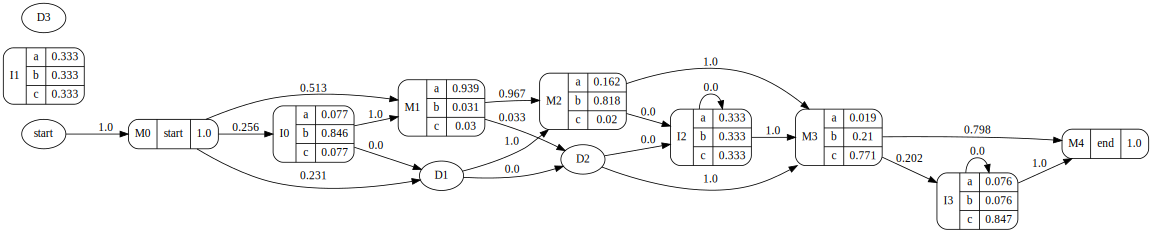

In [892]:
import graphviz
def pHMMviz(priors,states):
    g = graphviz.Digraph('G', filename='HHM.gv',engine='dot')
    g.attr(rankdir='LR', size='16,10')
    init = priors[0]
    tran = priors[1]
    emis = priors[2]
    numstates=int(max([i[1:] for i in states if 'M' in i]))+1
    for key in init:
        if init[key]>0.00:
            g.edge('start',str(key),label=str(round(init[key],3)),labeldistance='1')
    for row in tran.index:
        for col in tran.columns:
            if tran.loc[row,col]>0.0:
                g.edge(str(row),str(col),label=str(round(tran.loc[row,col],3)))
    for row in emis.index:
        strsymbol=''
        stremis=''
        for col in emis.columns:
            if emis.loc[row,col]>0.0:
                if strsymbol!='':
                    strsymbol+='|'
                    stremis+='|'
                strsymbol+=col
                stremis+=str(round(emis.loc[row,col],3))
        if str(row)=='end':
            g.node(str(row))
        elif row=='D0' or row=='I'+str(numstates-1) or row=='D'+str(numstates-1):
            continue
        elif 'D' in row:
            g.node(str(row),shape='oval')
        else:
            g.node(str(row),shape='Mrecord',label='{'+str(row)+'|{'+strsymbol+'}|{'+stremis+'}}')
    
    #for cnum in range(0,numstates-1):
    #    with g.subgraph(name='cluster'+str(cnum)) as c:
    #        c.node('M'+str(cnum))
    #        c.node('I'+str(cnum))
    #        if cnum>0:
    #            c.node('D'+str(cnum))
    #
    display(g)

pHMMviz(priors,states)

In [312]:
def correctseq(oldseq,tblist):
    newseq=[]
    iterval=0
    for tbval in tblist:
        if tbval=='M0' or tbval=='M4':
            continue
        elif 'M' in tbval or 'I' in tbval:
            newseq.append(oldseq[iterval])
            iterval+=1
        elif 'D' in tbval:
            newseq.append('-')
        else:
            print('ERROR')
    return newseq

In [313]:
def traceback(tbin):
    numcol=tbin.columns.tolist()[-1]
    numrow=tbin.index.tolist()[-1][0]
    nextval='M'+str(numrow)
    tblist=[nextval]
    while(numcol>=0):
        nextstate=nextval[0]
        nextnum=int(nextval[1:])
        nextval=tbin.loc[(nextnum,nextstate),numcol]
        tblist.insert(0,nextval)
        if nextstate!='D':
            numcol-=1
    return tblist[1:]

In [ ]:
states=['s','t']
symbols=['A','B']
init = {'s':0.85,'t':0.15}
tran = pd.DataFrame({'s':{'s':0.3,'t':0.7},'t':{'s':0.1,'t':0.9}}).transpose()
emis = pd.DataFrame({'s':{'A':0.4,'B':0.6},'t':{'A':0.5,'B':0.5}}).transpose()
priors=(init,tran,emis)
corpus={
    ('A','B','B','A'):{'count':10},
    ('B','A','B'):{'count':20},
    }
oldLL=-99999
acc=0.0001
for i in range(0,100):
    priors=baumwelch(corpus,priors,states,symbols)
    newLL=loglike(corpus,priors,states)
    if abs(oldLL-newLL)<acc:
        break
    else:
        oldLL=newLL
for value in priors:
    if type(value)==dict:
        display(value)
    elif type(value)==pd.core.frame.DataFrame:
        display(round(value,3))

In [597]:
states=['A','B']
symbols=['a','b1','b2']
init = {'A':0.8,'B':0.2}
tran = pd.DataFrame({'A':{'A':0.8,'B':0.2},'B':{'A':0.2,'B':0.8}}).transpose()
emis = pd.DataFrame({'A':{'a':0.8,'b1':0.1,'b2':0.1},'B':{'a':0.1,'b1':0.45,'b2':0.45}}).transpose()
priors=(init,tran,emis)
corpus=generatesequences(init,tran,emis,10)
#corpus={
#    ('a','a','a','b1','b2','b1','b1'):{'count':10},
#    ('b2','b2','b2','b1','a','a','a','a'):{'count':20},
#    }
#prior=randomizepriors(priors)
#
#oldLL=-99999
#acc=0.001
#for i in range(0,10000):
#    priors=baumwelch(corpus,priors,states,symbols)
#    newLL=loglike(corpus,priors,states)
#    #display(newLL)
#    if abs(oldLL-newLL)<acc:
#        display(str(i)+' iterations')
#        break
#    else:
#        oldLL=newLL
#for value in priors:
#    if type(value)==dict:
#        display(value)
#    elif type(value)==pd.core.frame.DataFrame:
#        display(round(value,3))

In [484]:
def maxdict(dictin):
    #dictin[num]=name
    value=max(dictin.keys())
    name=dictin[value]
    # ( '1M' , 0.003 )
    return (name,value)

def seqalign(seqin,priors):
    init = priors[0]
    tran = priors[1]
    emis = priors[2]
    sequence=list(seqin)
    sequence.insert(0,'start')
    sequence.append('end')
    numstates=int(max([i[1:] for i in list(init.keys()) if 'M' in i]))-1
    seqlen=len(sequence)-1
    seqrange=range(0,seqlen+1)
    staterange=range(0,numstates+2)
    statetypes=['M','D','I']
    vit=pd.DataFrame(0,
                index=pd.MultiIndex.from_product([staterange,statetypes]),
                columns=seqrange)
    tb=pd.DataFrame(0,
                index=pd.MultiIndex.from_product([staterange,statetypes]),
                columns=seqrange)
    #initialize
    vit.loc[(0,'M'),0]=1.0
    for i in range(0,len(sequence)): #sequence #
        for j in staterange: #state #
            for statetype in statetypes: #type of state
                curstatenum=statetype+str(j)
                prev={}
                #ignore M0 because we already initialized it
                #ignore D0, DN, IN because they don't exist
                if (statetype=='D' and j==0) or (statetype=='D' and j==numstates+1) or (statetype=='I' and j==numstates+1) or (statetype=='M' and j==0):
                    continue
                else: #state 0 is always M0
                    if statetype=='M' and i>0 and j>0: #M0=1.0 when i=0, so skip j=0. Also M1 cannot be true @ i=0, so skip i=0
                        for prevstatetype in statetypes:
                            prevstatenum=prevstatetype+str(j-1)
                            prev[vit.loc[(j-1,prevstatetype),i-1] * tran.loc[prevstatenum,curstatenum]]=prevstatenum
                        maxed=maxdict(prev)
                        if maxed[1]>0.0:
                            vit.loc[(j,statetype),i]=maxed[1] * emis.loc[curstatenum,sequence[i]]
                            tb.loc[(j,statetype),i]=maxed[0]
                    elif statetype=='I' and i>0: #M0=1.0 when i=0, so skip i=0, but don't skip j=0 since I0 exists
                        for prevstatetype in statetypes:
                            prevstatenum=prevstatetype+str(j)
                            prev[vit.loc[(j,prevstatetype),i-1] * tran.loc[prevstatenum,curstatenum]]=prevstatenum
                        maxed=maxdict(prev)
                        if maxed[1]>0.0:
                            vit.loc[(j,statetype),i]=maxed[1] * emis.loc[curstatenum,sequence[i]]
                            tb.loc[(j,statetype),i]=maxed[0]
                    elif statetype=='D' and j>0: #no D0, but M0->D1 still keeps i at 0, so don't skip i=0
                        for prevstatetype in statetypes:
                            prevstatenum=prevstatetype+str(j-1)
                            prev[vit.loc[(j-1,prevstatetype),i] * tran.loc[prevstatenum,curstatenum]]=prevstatenum
                        maxed=maxdict(prev)
                        if maxed[1]>0.0:
                            vit.loc[(j,statetype),i]=maxed[1]
                            tb.loc[(j,statetype),i]=maxed[0]
    #display(vit)
    #display(tb)
    return traceback(tb)

In [560]:
def initializephmm(numstates,symbols):
    states=[]
    numsymbols=len(symbols)
    symbols.append('start')
    symbols.append('end')
    
    #states
    for i in range(0,numstates+2):
        states.append('M'+str(i))
        states.append('D'+str(i))
        states.append('I'+str(i))
    
    #init
    init={}
    for state in states:
        init[state]=0.0
    init['M0']=1.0
    
    #tran
    exclude=['D0','I'+str(numstates+1),'D'+str(numstates+1)]
    tran={}
    for state1 in states:
        i=state1[1:]
        tran[state1]={}
        for state2 in states:
            j=state2[1:]
            if state1 in exclude or state2 in exclude:
                tran[state1][state2]=0.0
            elif int(i)==int(j)-1 and 'M' in state2:
                if int(i)==numstates:
                    tran[state1][state2]=0.9
                else:
                    tran[state1][state2]=0.8
            elif int(i)==int(j) and 'I' in state2:
                tran[state1][state2]=0.1
            elif int(i)==int(j)-1 and 'D' in state2:
                tran[state1][state2]=0.1
            else:
                tran[state1][state2]=0.0
    tran=pd.DataFrame(tran).transpose()
    
    #emis
    emis={}
    for state in states:
        emis[state]={}
        for symbol in symbols:
            if state=='M0':
                if symbol=='start':
                    emis[state][symbol]=1.0
                else:
                    emis[state][symbol]=0.0
            elif state=='M'+str(numstates+1):
                if symbol=='end':
                    emis[state][symbol]=1.0
                else:
                    emis[state][symbol]=0.0
            elif state in exclude or 'D' in state:
                emis[state][symbol]=0.0
            elif symbol!='start' and symbol!='end':
                emis[state][symbol]=(random.random()-0.5)/2+0.5
            else:
                emis[state][symbol]=0.0
    emis=pd.DataFrame(emis).transpose()
    for row in states:
        total=sum(emis.loc[row,:])
        if total>0:
            emis.loc[row,:]/=total
    
    
    priors=(init,tran,emis)
    
    return(priors, states)

In [590]:
def ploglike(corpus,priors,states,symbols):
    LL=0
    palpha(corpus,priors,states,symbols)
    for seq in corpus:
        LL+=corpus[seq]['count']*np.log(corpus[seq]['prob'])
    return LL
#ploglike(corpus,priors,states,symbols)

In [591]:
def pbaumwelch(corpus,priors,states,symbols):
    for i in range(0,20):
        palpha(corpus,priors,states,symbols)
        pbeta(corpus,priors,states,symbols)
        newemis=pnewemis(corpus,priors,states,symbols)
        newtran=pnewtran(corpus,priors,states,symbols)
        priors=(priors[0],newtran,newemis)
        display(ploglike(corpus,priors,states,symbols))
    pHMMviz(priors,states)
    for seq in corpus:
        display(seq)
        display(correctseq(seq,seqalign(seq,priors)))
    return priors
#priors=pbaumwelch(corpus,priors,states,symbols)

In [720]:
def palpha(corpus,priors,states,symbols):
    init = priors[0]
    tran = priors[1]
    emis = priors[2]
    numstates=int(max([i[1:] for i in states if 'M' in i]))+1
    for curseq in corpus:
        seq=list(curseq)
        seq.insert(0,'start')
        seq.append('end')
        alpha=pd.DataFrame(0.0,index=states,columns=range(0,len(seq)))
        alpha.loc['M0',0]=1.0
        for i in range(0,len(seq)):
            for k in range(0,numstates):
                #M
                if k>0 and i>0:
                    eterm=emis.loc['M'+str(k),seq[i]]
                    mterm=alpha.loc['M'+str(k-1),i-1]*tran.loc['M'+str(k-1),'M'+str(k)]
                    iterm=alpha.loc['I'+str(k-1),i-1]*tran.loc['I'+str(k-1),'M'+str(k)]
                    dterm=alpha.loc['D'+str(k-1),i-1]*tran.loc['D'+str(k-1),'M'+str(k)]
                    alpha.loc['M'+str(k),i]=eterm*(mterm+iterm+dterm)
                #I
                if i>0:
                    eterm=emis.loc['I'+str(k),seq[i]]
                    mterm=alpha.loc['M'+str(k),i-1]*tran.loc['M'+str(k),'I'+str(k)]
                    iterm=alpha.loc['I'+str(k),i-1]*tran.loc['I'+str(k),'I'+str(k)]
                    dterm=alpha.loc['D'+str(k),i-1]*tran.loc['D'+str(k),'I'+str(k)]
                    alpha.loc['I'+str(k),i]=eterm*(mterm+iterm+dterm)
                #D
                if k>0:
                    mterm=alpha.loc['M'+str(k-1),i]*tran.loc['M'+str(k-1),'D'+str(k)]
                    iterm=alpha.loc['I'+str(k-1),i]*tran.loc['I'+str(k-1),'D'+str(k)]
                    dterm=alpha.loc['D'+str(k-1),i]*tran.loc['D'+str(k-1),'D'+str(k)]
                    alpha.loc['D'+str(k),i]=(mterm+iterm+dterm)

        corpus[curseq]['alpha']=alpha
        corpus[curseq]['prob']=alpha.loc['M'+str(numstates-1),len(seq)-1]
        #display(alpha)
        
#palpha(corpus,priors,states,symbols)
#for seq in corpus:
#    display(corpus[seq]['alpha'])

In [721]:
def pbeta(corpus,priors,states,symbols):
    init = priors[0]
    tran = priors[1]
    emis = priors[2]
    numstates=int(max([i[1:] for i in states if 'M' in i]))+1
    for curseq in corpus:
        seq=list(curseq)
        seq.insert(0,'start')
        seq.append('end')
        beta=pd.DataFrame(0.0,index=states,columns=range(0,len(seq)))
        beta.loc['M'+str(numstates-1),len(seq)-1]=1.0
        for i in range(len(seq)-1,-1,-1):
            for k in range(numstates-1,-1,-1):
                for state in ['M','D','I']:
                    #from M @ k+1
                    if k<numstates-1 and i<len(seq)-1:
                        bterm=beta.loc['M'+str(k+1),i+1]
                        tterm=tran.loc[state+str(k),'M'+str(k+1)]
                        eterm=emis.loc['M'+str(k+1),seq[i+1]]
                        beta.loc[state+str(k),i]+=(bterm*tterm*eterm)
                    #from I @ k
                    if i<len(seq)-1:
                        bterm=beta.loc['I'+str(k),i+1]
                        tterm=tran.loc[state+str(k),'I'+str(k)]
                        eterm=emis.loc['I'+str(k),seq[i+1]]
                        beta.loc[state+str(k),i]+=(bterm*tterm*eterm)
                    #from D @ k+1
                    if k<numstates-1:
                        bterm=beta.loc['D'+str(k+1),i]
                        tterm=tran.loc[state+str(k),'D'+str(k+1)]
                        eterm=emis.loc['D'+str(k+1),seq[i]]
                        beta.loc[state+str(k),i]+=(bterm*tterm*eterm)
        corpus[curseq]['beta']=beta
        #display(beta)    
                
#pbeta(corpus,priors,states,symbols)
#for seq in corpus:
#    display(corpus[seq]['beta'])

In [776]:
def pnewemis(corpus,priors,states,symbols):
    init = priors[0]
    tran = priors[1]
    emis = priors[2]
    numstates=int(max([i[1:] for i in states if 'M' in i]))+1
    newemis=pd.DataFrame(0.0,index=states,columns=symbols)
    #pseudocounts
    for state in states:
        for symbol in symbols:
            if (symbol!='start') and (symbol!='end') and (state!='M0') and (state!='D0') and (str(numstates-1) not in state) and ('D' not in state):
                newemis.loc[state,symbol]=1.0
    #populate
    for curseq in corpus:
        seq=list(curseq)
        seq.insert(0,'start')
        seq.append('end')
        tempdf=corpus[curseq]['alpha']*corpus[curseq]['beta']
        for i in range(0,len(seq)):
            cursymbol=seq[i]
            for state in states:
                if 'I' in state or 'M' in state:
                    newemis.loc[state,cursymbol]+=tempdf.loc[state,i]/corpus[curseq]['prob']*corpus[curseq]['count']
    #display(newemis)
    return normbyrow(newemis)

#pnewemis(corpus,priors,states,symbols)

In [777]:
def pnewtran(corpus,priors,states,symbols):
    init = priors[0]
    tran = priors[1]
    emis = priors[2]
    numstates=int(max([i[1:] for i in states if 'M' in i]))+1
    newtran=pd.DataFrame(0.0,index=states,columns=states)
    for curseq in corpus:
        seq=list(curseq)
        seq.insert(0,'start')
        seq.append('end')
        for k in range(0,numstates):
            for state in ['M','I','D']:
                for i in range(0,len(seq)):
                    #to M @ k+1
                    if i<len(seq)-1 and k<numstates-1:
                        aterm=corpus[curseq]['alpha'].loc[state+str(k),i]
                        tterm=tran.loc[state+str(k),'M'+str(k+1)]
                        eterm=emis.loc['M'+str(k+1),seq[i+1]]
                        bterm=corpus[curseq]['beta'].loc['M'+str(k+1),i+1]
                        newtran.loc[state+str(k),'M'+str(k+1)]+=(aterm*bterm*eterm*tterm)/corpus[curseq]['prob']*corpus[curseq]['count']

                    #to I @ k
                    if i<len(seq)-1:
                        aterm=corpus[curseq]['alpha'].loc[state+str(k),i]
                        tterm=tran.loc[state+str(k),'I'+str(k)]
                        eterm=emis.loc['I'+str(k),seq[i+1]]
                        bterm=corpus[curseq]['beta'].loc['I'+str(k),i+1]
                        newtran.loc[state+str(k),'I'+str(k)]+=(aterm*bterm*eterm*tterm)/corpus[curseq]['prob']*corpus[curseq]['count']

                    #to D @ k+1
                    if k<numstates-1:
                        aterm=corpus[curseq]['alpha'].loc[state+str(k),i]
                        tterm=tran.loc[state+str(k),'D'+str(k+1)]
                        bterm=corpus[curseq]['beta'].loc['D'+str(k+1),i]
                        newtran.loc[state+str(k),'D'+str(k+1)]+=(aterm*bterm*eterm*tterm)/corpus[curseq]['prob']*corpus[curseq]['count']
                    
    #display(normbyrow(newtran))
    return normbyrow(newtran)
    
#pnewtran(corpus,priors,states,symbols)

In [757]:
def normbyrow(dfin):
    for row in dfin.index:
        tot=sum(dfin.loc[row,:])
        if tot>0:
            dfin.loc[row,:]/=tot
    return dfin

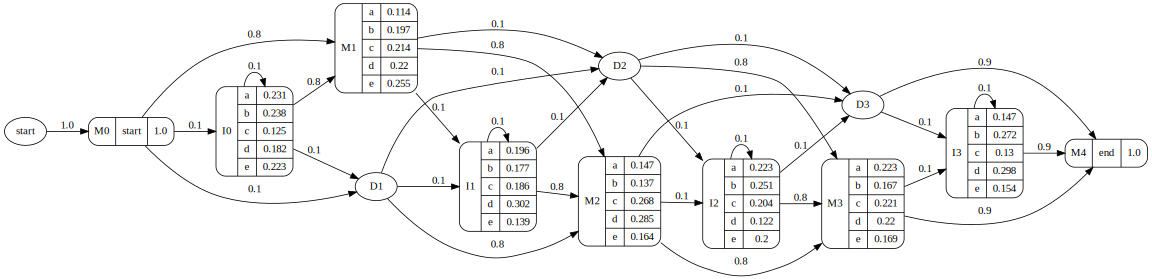

In [923]:
symbols=['a','b','c','d','e']
(priors,states)=initializephmm(3,symbols)
pHMMviz(priors,states)
corpus={
    ('a','b','c'):{'count':10},
    ('a','c','b'):{'count':10},
    ('a','b'):{'count':10},
    ('a','c'):{'count':10},
    ('a','b','c','c'):{'count':10},
    ('b','a','b','c'):{'count':10},
    #('b','a','b'):{'count':50},
}

-242.41581371672976

-223.54985050597685

-212.18750005146825

-198.06086128402811

-184.28315957038734

-180.5672752925955

-180.11411479102526

-179.94943291205345

-179.80527088546361

-179.56221119067939

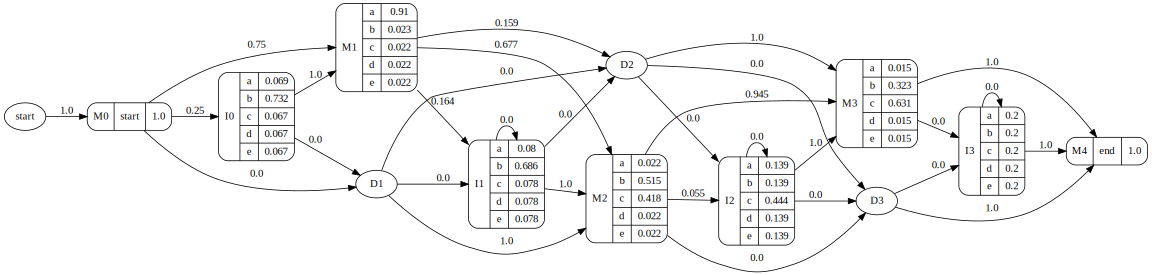

In [924]:
for i in range(0,10):
    palpha(corpus,priors,states,symbols)
    pbeta(corpus,priors,states,symbols)
    newemis=pnewemis(corpus,priors,states,symbols)
    newtran=pnewtran(corpus,priors,states,symbols)
    priors=(priors[0],newtran,newemis)
    display(ploglike(corpus,priors,states,symbols))
pHMMviz(priors,states)

In [926]:
for seq in corpus:
    display(seq)
    display(corpus[seq]['prob'])

('a', 'b', 'c')

0.14200642063870392

('a', 'c', 'b')

0.058954542064742703

('a', 'b')

0.035036559426169817

('a', 'c')

0.068405875527199941

('a', 'b', 'c', 'c')

0.022825143482192625

('b', 'a', 'b', 'c')

0.03474230485819154